In [25]:
from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d

from collections import defaultdict
import itertools

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

# 1. Read Data

In [26]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

data = TBAs[4.5]['2010-01-01':]
prices = data.price.values
rates = data.MTGFNCL.values / 100

ret = (prices[1:] - prices[:-1]) / prices[:-1]
delta_r = rates[1:] - rates[:-1]

full_dates = data.index
ret_dates = data.index[1:]

# 2. Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$price = \alpha_t + \beta_t * rate$$

or

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

$$duration = -\frac{price(rate + \Delta r) - price(rate - \Delta r)}{2\Delta r * price}$$

## 2.1 Duration from rolling window as benchmark

In [27]:
window_120 = 120
D_120 = []
for t in range(len(delta_r) - window_120):
    y = ret[t : t+window_120]
    x = delta_r[t : t+window_120]
    model = sm.OLS(y, x)
    result = model.fit()
    D_120.append(- result.params[0])

In [28]:
window_120 = 120
D2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_120.append(- result.params[0] / y[-1])

In [29]:
window_120 = 120
init_a = 0   # to initialize FK initial state
init_b = 0
Da2_120 = []
for t in range(len(rates) - window_120):
    y = prices[t : t+window_120]
    x = rates[t : t+window_120]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_120.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])
    init_a = result.params[0]
    init_b = result.params[1]

In [30]:
window_20 = 20
D_20 = []
for t in range(len(delta_r) - window_20):
    y = ret[t : t+window_20]
    x = delta_r[t : t+window_20]
    model = sm.OLS(y, x)
    result = model.fit()
    D_20.append(- result.params[0])

In [31]:
window_20 = 20
D2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
    result = model.fit()
    D2_20.append(- result.params[0] / y[-1])

In [32]:
window_20 = 20
Da2_20 = []
for t in range(len(rates) - window_20):
    y = prices[t : t+window_20]
    x = rates[t : t+window_20]
    model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
    result = model.fit()
    Da2_20.append(- (2 * result.params[0] * x[-1] + result.params[1]) / y[-1])

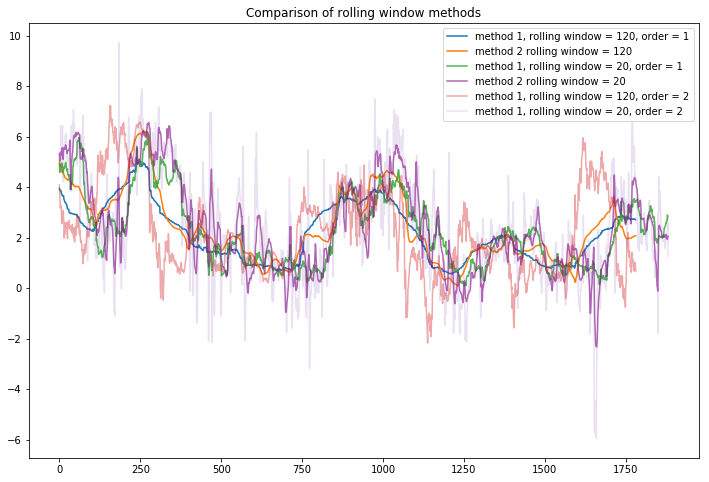

In [33]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot(D_120, label = 'method 1, rolling window = 120, order = 1')
ax.plot(D2_120, label = 'method 2 rolling window = 120')
ax.plot(D_20, label = 'method 1, rolling window = 20, order = 1', alpha = 0.8)
ax.plot(D2_20, label = 'method 2 rolling window = 20', c = 'purple', alpha = 0.6)
ax.plot(Da2_120, label = 'method 1, rolling window = 120, order = 2', alpha = 0.4)
ax.plot(Da2_20, label = 'method 1, rolling window = 20, order = 2', alpha = 0.2)
ax.set_title('Comparison of rolling window methods')
ax.legend()

## 2.2 Kalman Filter

In [34]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    kf_r = kf_r.em(y)
    state_means_beta, _ = kf_r.filter(y)
    state_means_beta_smooth, _ = kf_r.smooth(y)
    
    return state_means_beta, state_means_beta_smooth

In [35]:
def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window):

    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix 
    
    rates_window = Rates[window:Total_T + window]
    
    if dim == 2:
        obs_mat_r = np.expand_dims(np.vstack((rates_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack((rates_window**2, rates_window, np.ones(Total_T))).T, axis=1)
    
    delta_r = 0.001
    r_plus = rates_window + delta_r
    r_minus = rates_window - delta_r
    if dim == 2:
        x_plus = np.expand_dims(np.vstack((r_plus, np.ones(Total_T))).T, axis=1).squeeze()
        x_minus = np.expand_dims(np.vstack((r_minus, np.ones(Total_T))).T, axis=1).squeeze()
    else:
        x_plus = np.expand_dims(np.vstack((r_plus**2, r_plus, np.ones(Total_T))).T, axis=1).squeeze()
        x_minus = np.expand_dims(np.vstack((r_minus**2, r_minus, np.ones(Total_T))).T, axis=1).squeeze()
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta, mean_beta_smooth = beta_from_kalman_filter(np.eye(dim) * state_cov,obs_cov,np.eye(dim) * trans_cov,ini_mean, Prices[window:Total_T + window], obs_mat_r)
        
        y_minus = np.sum(x_minus * mean_beta, axis = 1).squeeze()
        y_plus = np.sum(x_plus * mean_beta, axis = 1).squeeze()
        duration = - (y_plus - y_minus) / (2 * delta_r * Prices[:Total_T])
        y_minus_sm = np.sum(x_minus * mean_beta_smooth, axis = 1).squeeze()
        y_plus_sm = np.sum(x_plus * mean_beta_smooth, axis = 1).squeeze()
        duration_smooth = - (y_plus_sm - y_minus_sm) / (2 * delta_r * Prices[:Total_T])

        dur[test_case] = duration
        dur_smooth[test_case] = duration_smooth
        
    return dur, dur_smooth

In [36]:
def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    
    dur= {}
    dur_smooth = {}
    dim = len(ini_mean)
    
    delta_r_window = delta_r[window:Total_T + window]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov = test_case
        mean_beta, mean_beta_smooth = beta_from_kalman_filter(np.eye(dim) * state_cov,obs_cov,np.eye(dim) * trans_cov,ini_mean, ret[window:Total_T + window], obs_mat_r)
        
        duration = - mean_beta[:,0]
        duration_smooth =  - mean_beta_smooth[:,0]
        
        dur[test_case] = duration
        dur_smooth[test_case] = duration_smooth
        
    return dur, dur_smooth

## 2.3. Kalman Filter for method 2: $price = \alpha_t + \beta_t * rate$

The transition covariance and initial mean need to be scaled, since here the state variable is $\beta = - duration * price$

In [37]:
ini_mean = [-D2_120[0] * prices[window_120], 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

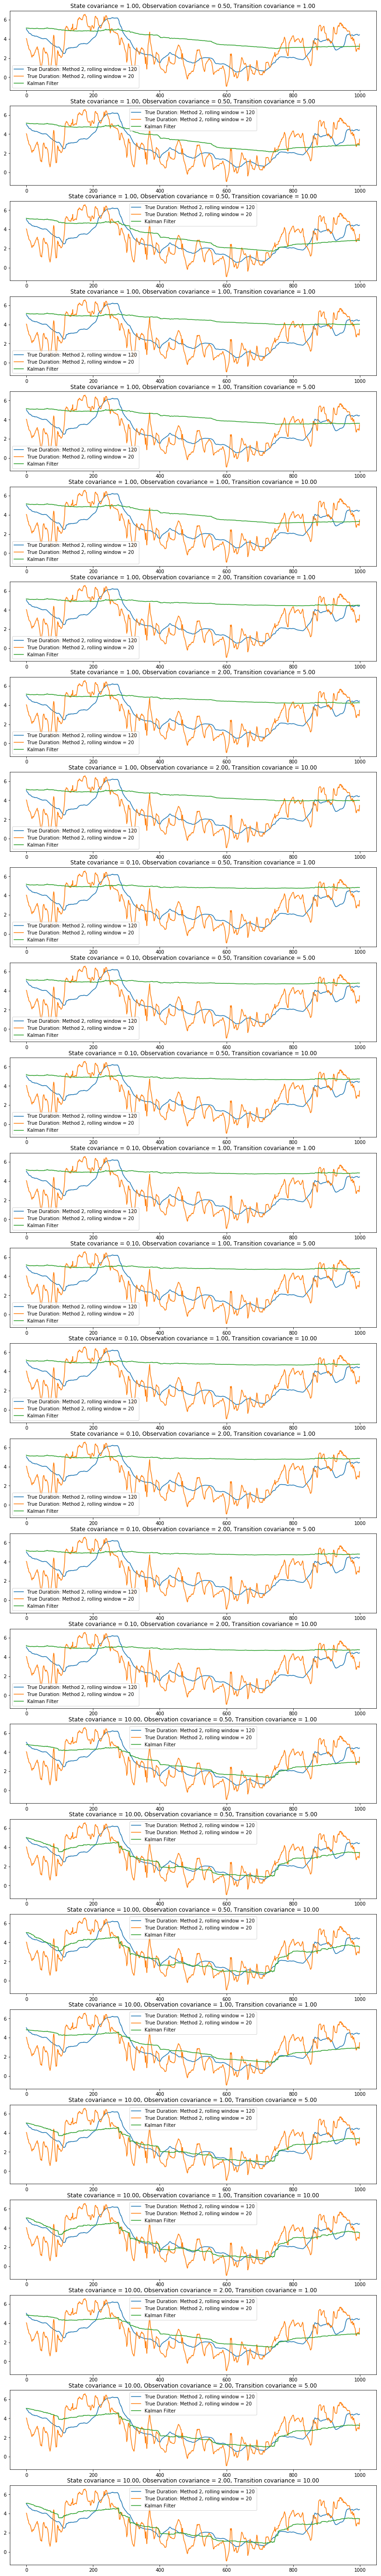

In [38]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D2_120[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(D2_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

## 2.4. Kalman Filter for method 2: $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$

In [39]:
#ini_mean = [(-D2_120[0] * prices[window_120] - 50) / (2 * rates[window_120]), 50, 0]   # randomly picked  
ini_mean = [init_a, init_b, 0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([1, 5, 10])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120)

runing for case :  (1.0, 0.5, 1)
runing for case :  (1.0, 0.5, 5)
runing for case :  (1.0, 0.5, 10)
runing for case :  (1.0, 1.0, 1)
runing for case :  (1.0, 1.0, 5)
runing for case :  (1.0, 1.0, 10)
runing for case :  (1.0, 2.0, 1)
runing for case :  (1.0, 2.0, 5)
runing for case :  (1.0, 2.0, 10)
runing for case :  (0.10000000000000001, 0.5, 1)
runing for case :  (0.10000000000000001, 0.5, 5)
runing for case :  (0.10000000000000001, 0.5, 10)
runing for case :  (0.10000000000000001, 1.0, 1)
runing for case :  (0.10000000000000001, 1.0, 5)
runing for case :  (0.10000000000000001, 1.0, 10)
runing for case :  (0.10000000000000001, 2.0, 1)
runing for case :  (0.10000000000000001, 2.0, 5)
runing for case :  (0.10000000000000001, 2.0, 10)
runing for case :  (10.0, 0.5, 1)
runing for case :  (10.0, 0.5, 5)
runing for case :  (10.0, 0.5, 10)
runing for case :  (10.0, 1.0, 1)
runing for case :  (10.0, 1.0, 5)
runing for case :  (10.0, 1.0, 10)
runing for case :  (10.0, 2.0, 1)
runing for case 

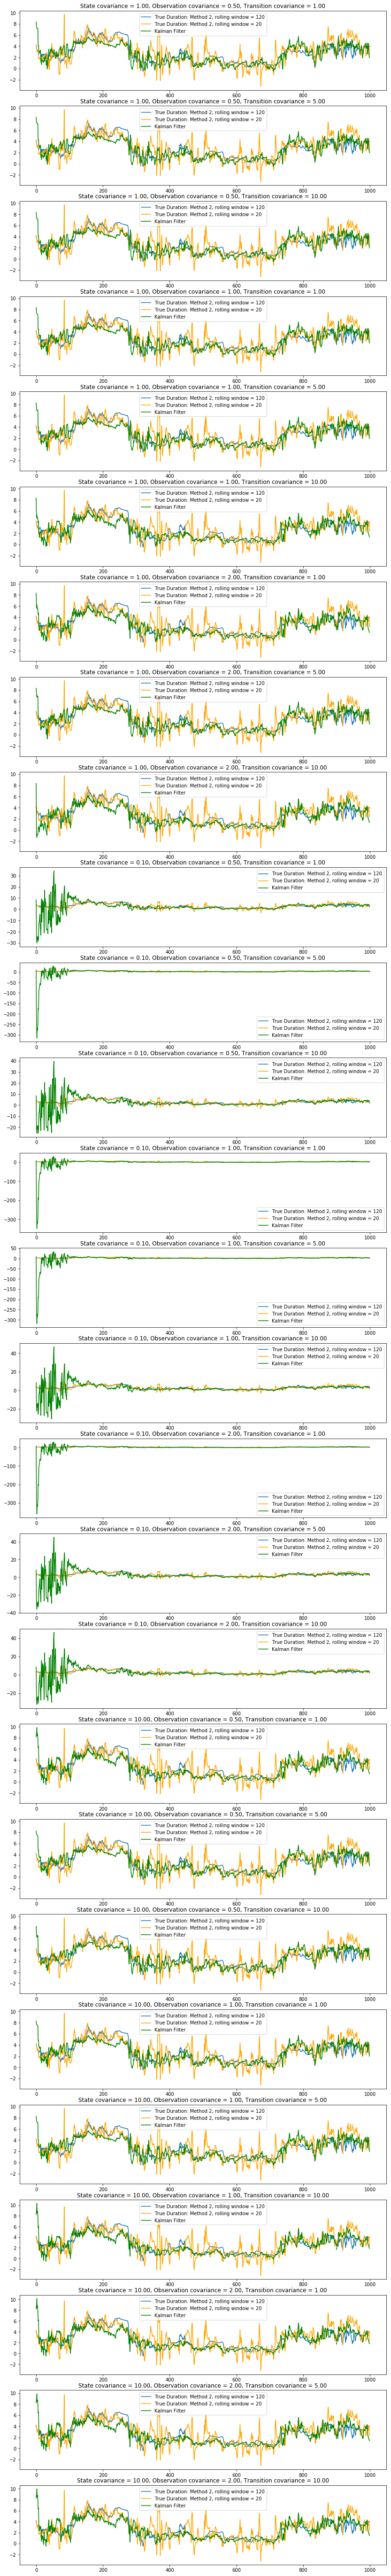

In [40]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(Da2_120[:Total_T], label = 'True Duration: Method 2, rolling window = 120')
    ax.plot(Da2_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 2, rolling window = 20', c = 'orange')
    ax.plot(single_dur, label = 'Kalman Filter', c = 'green')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

**There are some jump in KF method when state covariance = 0.1, because of the initial state selection. We are looking for better ways to initiate the initial state.**

## 2.5. Kalman Filter for method 1: $\frac{\Delta price}{price} = - duration_t * \Delta rate$

In [41]:
ini_mean = [-D_120[0],0]
state_cov = np.array([1, 0.1, 10])
obs_cov = np.array([0.5, 1, 2])
trans_cov = np.array([0.001, 0.01, 0.1])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov))

Total_T = 1000
dur, dur_smooth = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120)

runing for case :  (1.0, 0.5, 0.001)
runing for case :  (1.0, 0.5, 0.01)
runing for case :  (1.0, 0.5, 0.10000000000000001)
runing for case :  (1.0, 1.0, 0.001)
runing for case :  (1.0, 1.0, 0.01)
runing for case :  (1.0, 1.0, 0.10000000000000001)
runing for case :  (1.0, 2.0, 0.001)
runing for case :  (1.0, 2.0, 0.01)
runing for case :  (1.0, 2.0, 0.10000000000000001)
runing for case :  (0.10000000000000001, 0.5, 0.001)
runing for case :  (0.10000000000000001, 0.5, 0.01)
runing for case :  (0.10000000000000001, 0.5, 0.10000000000000001)
runing for case :  (0.10000000000000001, 1.0, 0.001)
runing for case :  (0.10000000000000001, 1.0, 0.01)
runing for case :  (0.10000000000000001, 1.0, 0.10000000000000001)
runing for case :  (0.10000000000000001, 2.0, 0.001)
runing for case :  (0.10000000000000001, 2.0, 0.01)
runing for case :  (0.10000000000000001, 2.0, 0.10000000000000001)
runing for case :  (10.0, 0.5, 0.001)
runing for case :  (10.0, 0.5, 0.01)
runing for case :  (10.0, 0.5, 0.1000

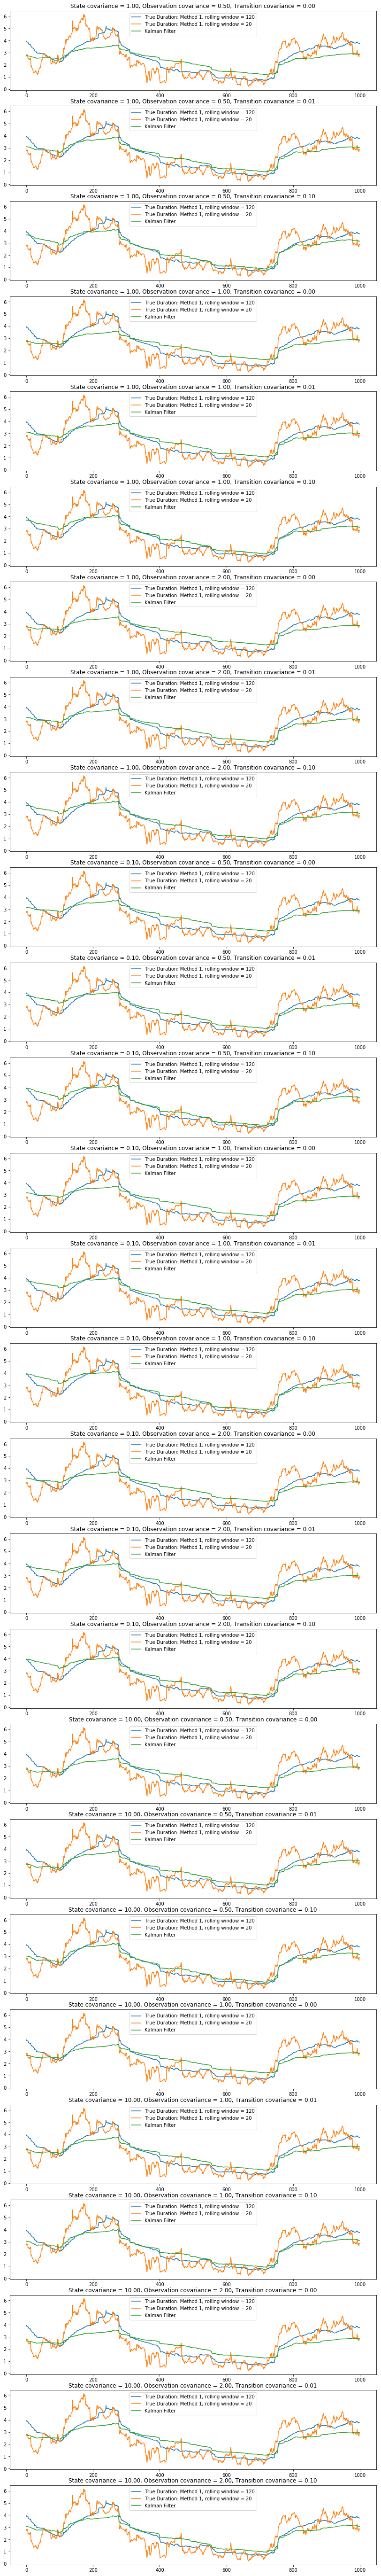

In [42]:
fig = plt.figure(figsize=(14,100))
size = len(all_test_cases)
for i, test_case in enumerate(all_test_cases, 1):
    single_dur = dur[test_case]
    ax = fig.add_subplot(size, 1, i)
    ax.plot(D_120[:Total_T], label = 'True Duration: Method 1, rolling window = 120')
    ax.plot(D_20[window_120 - window_20:Total_T + window_120 - window_20], label = 'True Duration: Method 1, rolling window = 20')
    ax.plot(single_dur, label = 'Kalman Filter')
    ax.legend()
    ax.set_title('State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(test_case[0], test_case[1], test_case[2]))

# 3. Heding

## 3.1. Duration Hedging

Using swaption as the heding instrument.

step 1) calculate dollar duration of both TBAs and swaption
$$\text{hedge ratio} = \dfrac{DV01_(\text{TBAs})}{DV01_(\text{swaption})}$$
step 2) construct hedged portfolio $$\Pi = \text{TBA} - \text{hedge ratio}\times \text{swaption} $$
step 3) compare the return and variance between the portfolio and naked position

### Generate Duration

In [43]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)

    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    kf_r = kf_r.em(y)
    state_means_beta, _ = kf_r.filter(y)
    state_means_beta_smooth, _ = kf_r.smooth(y)
    
    return state_means_beta, state_means_beta_smooth

In [44]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = 'data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

In [45]:
state_cov_coeff = 1
obs_cov_coeff = 0.5
trans_cov_coeff = 0.001

state_cov = np.eye(2) * state_cov_coeff
obs_cov = obs_cov_coeff
trans_cov = np.eye(2) * trans_cov_coeff

default_window = 60

poly_duration_without_order = {}
for c, period_list in collapse_without_order.items():
    dat = TBAs[c]
    
    cur_list = []
    for p in period_list:
        prices = dat[p.startDate:p.endDate]['price']
        rates = dat[p.startDate:p.endDate]['MTGFNCL']
        
        ret = (prices[1:].values - prices[:-1].values) / prices[:-1].values
        delta_r = rates[1:].values - rates[:-1].values

        window = default_window
        rolling_period = len(prices)
        
        if rolling_period < window:
            window = rolling_period // 2 + 1
        
        model = sm.OLS(ret[:window], delta_r[:window])
        result = model.fit()
        ini_mean = [result.params[0],0]
        
        dates = dat[p.startDate:p.endDate].index
        
        X = np.expand_dims(np.vstack((rates.values, np.ones(len(rates)))).T, axis = 1)
        
        betas, _ = beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, prices.values, X)
        
        cur_list.append(pd.DataFrame({'Duration' : -betas[:, 0]}, index = dates))
        
    poly_duration_without_order[c] = cur_list

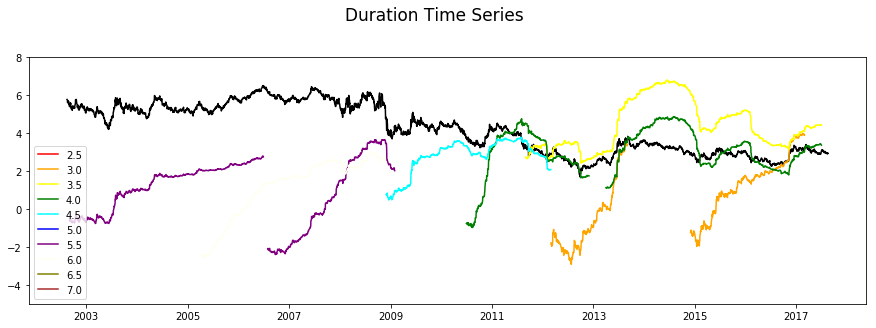

In [46]:
def getUniqLabel(handles, labels):
    uniq_label= {}
    for idx, lab in enumerate(labels):
        if lab not in uniq_label.keys():
            uniq_label[lab] = handles[idx]
    return uniq_label

color_code = {
    2.5: 'red',
    3.0: 'orange',
    3.5: 'yellow',
    4.0: 'green',
    4.5: 'cyan',
    5.0: 'blue',
    5.5: 'purple',
    6.0: 'ivory',
    6.5: 'olive',
    7.0: 'brown',
    7.5: 'khaki',
    8.0: 'mediumslateblue',
    
}

fig = plt.figure(figsize = (15,10))
plt.suptitle('Duration Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
ax.plot(rate_Base.index, rate_Base['MTGFNCL'].values, color = 'black')
for c, duration_list in poly_duration_without_order.items():
    for d in duration_list:
        ax.plot(d.index, d.Duration, c = color_code[c],label=c)
ax.set_ylim([-5, 8])
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys())

### Hedging using 10y treasury

In [47]:
tenor=10
frq=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30])
term_structure = pd.read_excel('treasury term structure.xlsx',index_col=0, header=0,names=frq) 
swp_dur = pd.read_csv('tsy5y+10y.csv',index_col=0, header=0, skiprows=0)['10 year note Current Modified Duration']
swp_dur=pd.DataFrame(np.array(swp_dur),columns=['swap_duration'],index=swp_dur.index)
swp_dur.index=pd.to_datetime(swp_dur.index, format='%Y-%m-%d')
one_day_return = pd.read_excel('1day-return_USD10Y.xlsx',index_col=0, header=0) 
term_structure.index=pd.to_datetime(term_structure.index, format='%Y%m%d')
one_day_return.index=pd.to_datetime(one_day_return.index, format='%Y%m%d')

FileNotFoundError: [Errno 2] No such file or directory: 'treasury term structure.xlsx'

In [ ]:
notional=1
tc_ratio=0
startDate=pd.to_datetime('2002-1-1', format='%Y-%m-%d')
result=[]
hedge_frq=5
for c in poly_duration_without_order.keys(): #iterate for all coupons
    for item in poly_duration_without_order[c]: #iterate for all windows
        hedge=pd.DataFrame(item)
        for i,dataDate in enumerate(hedge.index):
            if dataDate >= startDate and len(hedge.index[i:])>1:
                hedgeUse=hedge[i:]
                nakedR=[np.nan]
                portfolioR=[np.nan]
                hr=[np.nan]
                d0=hedgeUse.index[0]
                for j,d1 in enumerate(hedgeUse.index[1::hedge_frq]):
                    d0=hedgeUse.index[j*hedge_frq]
                    try:
                        hedgeRatio=(hedgeUse['Duration'][d0])/(swp_dur.loc[d0]['swap_duration']) #*TBAs[c].price[d0]/100
                        dmin=d0
                        for d in hedgeUse.index[j*hedge_frq+1:j*hedge_frq+1+hedge_frq]:
                            nakedReturn = (TBAs[c].price[d]-TBAs[c].price[dmin])/TBAs[c].price[dmin]
                            hedgedReturn=nakedReturn-notional*hedgeRatio*float(one_day_return.loc[d])-tc_ratio
                            nakedR.append(nakedReturn)
                            portfolioR.append(hedgedReturn)
                            hr.append(hedgeRatio)
                            dmin=d
                    except:  
                        for d in hedgeUse.index[j*hedge_frq+1:j*hedge_frq+1+hedge_frq]:
                            nakedReturn=np.nan
                            hedgeRatio=np.nan
                            hedgedReturn=np.nan
                            nakedR.append(nakedReturn)
                            portfolioR.append(hedgedReturn)
                            hr.append(hedgeRatio)
                hedgeUse['hedge_Ratio']=hr
                hedgeUse['naked_return']=nakedR
                hedgeUse['hedged_return']=portfolioR
                result.append([c,hedgeUse])
                break

## 3.2. Plot Hedged Ratio

In [ ]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Hedged Ratio Time Series', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
for c, hedge_list in result:
    ax.plot(hedge_list.index, hedge_list['hedge_Ratio'], c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys())

## 3.3. Plot Hedging Performance

In [ ]:
fig = plt.figure(figsize = (15,10))
plt.suptitle('Return of Naked Position vs Hedged Position', y=0.95, fontsize=17)
ax = fig.add_subplot(211)
naked_returns={}
hedged_returns={}
for c, hedge_list in result:
    naked_returns[c]=[]
    hedged_returns[c]=[]
    ax.plot(hedge_list.index, hedge_list['naked_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Naked Position')

ax = fig.add_subplot(212)
for c, hedge_list in result:
    naked_returns[c].extend(hedge_list['naked_return'])
    hedged_returns[c].extend(hedge_list['hedged_return'])
    
    ax.plot(hedge_list.index, hedge_list['hedged_return'], alpha=0.5,c = color_code[c],label=c)
handles, labels = ax.get_legend_handles_labels()
uniq_label=getUniqLabel(handles, labels)
plt.legend(uniq_label.values(),uniq_label.keys()) 
plt.title('Hedged Position')
plt.show()

for c in naked_returns:
    x = np.array(naked_returns[c])
    x = x[np.logical_not(np.isnan(x))]
    y = np.array(hedged_returns[c])
    y = y[np.logical_not(np.isnan(y))]
    print('\n','coupon = ',c,'\n','naked  : mean = ',np.mean(x),', std = ',np.std(x),\
         '\n','hedged : mean = ',np.mean(y),', std = ',np.std(y))

In [ ]:
result